In [23]:
import h3ppy
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy.io as sio
import os
from pathlib import Path

In [3]:
#it's reccomended to play around with settings in h3ppy Test Fitting Routines before putting in finalized inputs here
#this notebook is just for using specific inputs to mass-run all h3ppy fits in a directory

In [17]:
#general path to pull data from
path = "Y:/obs_23/Keck_29Dec"


#wavelength files:
wave_e1o1_list = sio.readsav(path + r"\spec\e1o1\wavelength.sav", verbose=False, python_dict = True)
wave_micron1st = wave_e1o1_list['wavelength']

wave_e1o4_list = sio.readsav(path + r"\spec\e1o4\wavelength.sav", verbose=False, python_dict = True)
wave_micron4th = wave_e1o4_list['wavelength']


#widths of emission lines to crop from wider spectrum = this is a radius, not a diameter
widthpeak = 15
widthpeaklist = [7, 15, 15, 15]


#choose your emission lines:
#full list in e1o1, e1o3, e1o4: 3.41277, 3.41488, 3.42071, 3.42697, 3.45475, 3.62046, 3.95299


#center of chosen emission lines in data
centers_multi = [3.41488, 3.42071, 3.45475, 3.95299] #center of line peak in data
#center of chosen emission lines in h3ppy ("real" wavelength)
truecenters_multi = [3.41488, 3.42071, 3.45475, 3.95299] #actual wavelength of emission via h3ppy

#look into new ways of generating temperature array?
temps = [900, 1200, 1100, 1000, 800, 700, 1300, 1800, 600]

#inputs for h3ppy - essentially the coefficient for the polynomial being used to fit these variables
nbg = 0 #nth order polynomial for background fit
noff = 3 #nth order polynomial for correcting wavelength calibration (shift emission lines left/right)
nsig = 1 #nth order polynomial for line widths (must be 1 or greater)



#directories for saving final outputs & their corresponding fits
newpath = path + "/Final Temperatures & Densities"
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
newpath_fits = path + "/Final Temperatures & Densities/fits"
if not os.path.exists(newpath_fits):
    os.makedirs(newpath_fits)



#paths where data are currently stored for each order of data
#currently only set up for 2 orders of data (currently assuming using 1st and 4th)
your_path1 = path + "/spec/e1o1/Kate's Files/fcal data/interp"
your_path4 = path + "/spec/e1o4/Kate's Files/fcal data/interp"

In [18]:
#my variation of subdivide (from h3ppy github) to include emission lines from two orders/arrays of data
            #the only difference between this and subdivide is that it accepts 2 inputs for spec and wave & combines them
#wave1: wavelength values for first spectrum (1st order, microns)
#wave4: wavelength values for second spectrum (4th order, microns)
#spec1: first spectrum to be fit by h3ppy (1st order, W/m^2/micron/str)
#spec4: second spectrum to be fit by h3ppy (4th order, W/m^2/micron/str)
#middles: list of emission lines to be extracted (ACCORDING TO DATA) (microns)
#width: # of data points to be pulled from spectrum on either side of the middle of an emission line

def subdivide_doubleorder_multiwidth(wave1, wave2, spec1, spec2, middles, width = widthpeaklist): 
    
    #make sure lists of emission lines and their cut widths are same size
    if len(middles) != len(width):
        print("Number of emission lines does not equal size of widths to slice")
    
    else:
        spec = []
        wave = []
        for i in range(len(spec1)):#...i don't know the right way to put the arrays together
            spec.append(spec1[i])       #this works I guess, but it looks ugly
        for i in range(len(spec2)):
            spec.append(spec2[i])
        for i in range(len(wave1)):
            wave.append(wave1[i])
        for i in range(len(wave2)):
            wave.append(wave2[i])

        spec = np.array(spec)
        wave = np.array(wave)

        ret = []
        for x in range(len(middles)): #loop through for each emission line entered
            centre = np.abs(wave - middles[x]).argmin() #subtracts value of middle from all data points;
                                               #absolute value -> closest to 0 is the index of the peak
            for i in range(centre - width[x], centre + width[x]) : #finds boundaries for region you want to "cut out"
                ret.append(spec[i]) #append "cut out" piece of wavelength values to final array
        return np.array(ret)

In [19]:
#function to find median value of data from +/- "width" of slit positions to essentially smooth across slit positions (in spatial dimension)
widthdy = 3

def dy_median(data,width = widthdy):
    
    arr = []
    
    for i in range(len(data[:,1])):

        #everything within inner boundaries
        if i >= width and i < (len(data[:,1])-width):
            med = np.median(data[i-width:i+width,:], axis=0)
            arr.append(med)
        #getting all of the left edge stuff
        elif i<width:
            med = np.median(data[0:i+width,:], axis=0)
            arr.append(med)

        #getting all of the right edge stuff
        elif i>=(len(data[:,1])-width):
            med = np.median(data[i-width:len(data[:,1]), :], axis=0)
            arr.append(med)


        else:
            print("Unable to determine order: " + str(i))
            
    return arr

In [20]:
def line(x,m,b):
   return m * x + b

#only to be used on order 1!
def dy_wo_aurora1(data):
    
    dy = np.zeros([len(data), len(data[0])])
    summed = np.sum(data, axis = 1) #sum in wavelength direction to later find auroral peak
    
    

    x_values = np.linspace(0,len(summed),len(summed)) #array of values for "x-axis"

    popt, pcov = curve_fit(line,x_values,summed) #fit line to summed array - tends to have an anti-auroral positive slope
  
    flattened = np.sum(data, axis = 1)/ line(x_values, *popt) #eliminating slope of emission across slit
    

    #first looking for whether the max of the first auroral section is smaller than the max of the second 
    #if yes, aurora is on "right" side (from this perspective)
    if np.max(flattened[0:int(0.3*len(summed))]) < np.max(flattened[len(summed) - int(0.3*len(summed)):len(summed)]):
        #find index of auroral emission peak
        maxauroraindex = flattened[len(summed) - int(0.3*len(summed)):len(summed)].argmax() + len(summed) - int(0.3*len(summed))
        #find value of region between auroral index peak & midpoint of slit which is closest to 10% of the peak
        dropindex = maxauroraindex - int(0.30*len(summed))
        #print(dropindex)
        #apply dy to non-auroral region
        dy[:dropindex] = dy_median(data[:dropindex])
        
        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[dropindex:])):
            dy[dropindex + i] = data[dropindex + i]


    #first looking for whether the max of the first auroral section is larger than the max of the second 
    #if yes, aurora is on "left" side (from this perspective)
    elif np.max(flattened[0:int(0.3*len(summed))]) > np.max(flattened[len(summed) - int(0.3*len(summed)):len(summed)]):
        #find index of auroral emission peak
        maxauroraindex = flattened[0:int(0.3*len(summed))].argmax()
        #find value of region between auroral index peak & midpoint of slit which is closest to 10% of the peak
        dropindex = maxauroraindex + int(0.30*len(summed))
        #print(dropindex)
        #apply dy to non-auroral region
        dy[dropindex:] = dy_median(data[dropindex:])

        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[:dropindex])):
            dy[i] = data[i]

    else:
        print("Unable to determine aurora location")        

    return np.asarray(dy), dropindex


#only to be used on order 3 or 4!
def dy_wo_aurora34(data, index):
    
    dy = np.zeros([len(data), len(data[0])])
    summed = np.sum(data, axis = 1) #sum in wavelength direction to later find auroral peak

    
    if index >= len(summed)*0.5:
        #print("Aurora on Right")
        #use index found in pt 1
        dropindex = index
        #print(dropindex)
        #apply dy to non-auroral region
        dy[:dropindex] = dy_median(data[:dropindex])
        
        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[dropindex:])):
            #print(i)
            dy[dropindex + i] = data[dropindex + i]


    #if yes, aurora is on "left" side (from this perspective)
    elif index < len(summed)*0.5:
        #print("Aurora on Left")
        #use index found in pt 1
        dropindex = index
        #print(dropindex)
        #apply dy to non-auroral region
        dy[dropindex:] = dy_median(data[dropindex:])

        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[:dropindex])):
            #print(i)
            dy[i] = data[i]

    else:
        print("Unable to determine drop index location")

    return np.asarray(dy) #, np.abs(dropindex)

In [21]:
#function to loop through all spectra in array to fit with h3ppy and return temp, density, and errors
            #this version specific to using lines from a single order (CURRENTLY WORKING (?))
#wavelength: the array of wavelength values which correspond to the data being fed in (microns)
#data: the spectrum which is attempting to be fit by h3ppy (W/m^2/micron/str)
#middles: the values of the centers of the emission lines in the *data* (microns)
#truemiddles: the values of the centers of the corresponding emission lines in h3ppy (microns)
#temperatures: an array of temperature values for h3ppy to loop through (Kelvin)

def h3ppyfit_doubleorder_loop_multiwidth(wavelength1, wavelength4, data1x, data4x, middles, truemiddles, temperatures, nbg, noff, nsig):
       
        
    temp = []
    density = []
    temperror = []
    densityerror = []
    
    fitlist = []
    datalist = []
    wavelengthlist = []
    
    count = 0
    tempcount = 0
    fail = 0
    
    data1, aurora_index = dy_wo_aurora1(data1x)
    data4 = dy_wo_aurora34(data4x, aurora_index)

    
    for i in range(len(data1)):  
        
        subspec = subdivide_doubleorder_multiwidth(wavelength1, wavelength4, data1[i], data4[i], middles)
        subwave = subdivide_doubleorder_multiwidth(wavelength1, wavelength4, wavelength1, wavelength4, truemiddles)
        
        datalist.append(subspec)
        wavelengthlist.append(subwave)
        
        h3p = h3ppy.h3p()
        # Set the wavelength and the data
        
        #for 4 or 5 lines (including Q1)
        #h3p.set(wavelength = subwave, data = subspec, R = 30000, nbackground = 0, noffset = 3)
        
        h3p.set(wavelength = subwave, data = subspec, R = 30000, nbackground = nbg, noffset = noff, nsigma = nsig)
        
        #for 3 lines (not including Q1)
        #h3p.set(wavelength = subwave, data = subspec, R = 30000, nbackground = 0, noffset = 3, nsigma = 2)

        # We need to guess a temperature
        h3p.set(temperature = temperatures[0])

        # Let h3ppy try and guess a wavelength offset
        guess = h3p.guess_offset( verbose = False)
        # Guess the density and proceed with a five parameter fit
        h3p.guess_density(verbose = False)
        # Let h3ppy do the fitting - this will do a full five parameter fit
        fit = h3p.fit(verbose = False)
        
        
        vars, errs = h3p.get_results(verbose = False)
        
        
        if vars == False:
            
            
            
            while tempcount < len(temperatures) and vars == False:
                    
                h3p = h3ppy.h3p()
                # Set the wavelength and the data
                h3p.set(wavelength = subwave, data = subspec, R = 30000, nbackground = nbg, noffset = noff, nsigma = nsig)

                # We need to guess a temperature
                h3p.set(temperature = temperatures[tempcount])

                # Let h3ppy try and guess a wavelength offset
                guess = h3p.guess_offset( verbose = False)
                # Guess the density and proceed with a five parameter fit
                h3p.guess_density(verbose = False)
                # Let h3ppy do the fitting - this will do a full five parameter fit
                fit = h3p.fit(verbose = False)
                
                vars, errs = h3p.get_results(verbose = False)
                
                tempcount = tempcount + 1
                            
                    
            if tempcount >= len(temperatures) and vars == False:
                    temp.append(-666)
                    temperror.append(666)
                    density.append(-666)
                    densityerror.append(666)

                    fitlist.append(np.zeros(len(subwave)))

                    print("Unable to fit index " + str(count))

                    count = count + 1
                    tempcount = 0
                    fail = fail + 1
                
                
            
            #else:
            elif vars != False:
                temp.append(vars['temperature'])
                temperror.append(errs['temperature'])
                density.append(vars['density'])
                densityerror.append(errs['temperature'])
                
                fitlist.append(fit)
                
                count = count + 1
                tempcount = 0
            
            
            else:
                print("Error Determining Temperature Index")
                print(vars)
                print("Weird Shit: " + str(count))
            
            
        
        else:
            temp.append(vars['temperature'])
            temperror.append(errs['temperature'])
            density.append(vars['density'])
            densityerror.append(errs['density'])
            
            fitlist.append(fit)
            
            count = count + 1
            tempcount = 0
            
            
    
    return temp,temperror,density,densityerror,datalist,fitlist,fail

In [24]:
#create readme with info about the run
content = ( f"This file contains all relevant inputs for the h3ppy fitting routine used to fit these data.\n"
            f"\n"
            f"\n"
            f"Emission lines: {truecenters_multi}\n"
            f"Offset Emission lines: {centers_multi}\n"
            f"Line widths: {widthpeaklist}\n"
            f"Median: {widthdy}\n"
            f"Temperature List: {temps}\n"
            f"nbackground: {nbg}\n"
            f"noffset {noff}\n"
            f"nsigma: {nsig}"
          )


with open(newpath + "/README.txt", 'w') as file:
    file.write(content)

print("Created README File for this run.")



files1 = os.listdir(your_path1)
files4 = os.listdir(your_path4)

jup1_array = []
jup4_array = []
name_arr = []

count1 = 0
count4 = 0

for file1 in files1:
    if os.path.isfile(os.path.join(your_path1, file1)):
        f_name, f_ext = os.path.splitext(os.path.join(your_path1, file1))
        stringname = Path(f_name).stem
        editable = stringname.split('_')
        partialname = str([editable[1] + "_" + editable[2]])
        name_arr.append(partialname)
        jup1 = np.load(os.path.join(your_path1, file1))
        jup1_array.append(jup1)
        count1 = count1 + 1
print(count1)

for file4 in files4:
    if os.path.isfile(os.path.join(your_path4, file4)):     
        jup4 = np.load(os.path.join(your_path4, file4))
        jup4_array.append(jup4)
        count4 = count4 + 1
print(count4)

#tells you how many files just to make sure the same number of files are reading in for each order

Created README File for this run.
100
100


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\

[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\

Fit failed to converge - solution is numerially unstable 
Unable to fit index 2
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Saved File: 0082_JupN with 98.92 % successful fits
Saved File: 0083_JupS with 100.0 % successful fits
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit fa

Fit failed to converge - solution is numerially unstable 
Saved File: 0090_JupN with 100.0 % successful fits
Saved File: 0091_JupS with 100.0 % successful fits
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Saved File: 0092_JupN with 100.0 % successful fits
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution i

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to 

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to 

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Saved File: 0125_JupN with 99.46 % successful fits
Saved File: 0126_JupS with 100.0 % successful fits
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - sol

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Saved File: 0135_JupN with 100.0 % successful fits
Saved File: 0136_JupS with 100.0 % successful fits
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - sol

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to 

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to 

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to 

Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to converge - solution is numerially unstable 
Fit failed to 

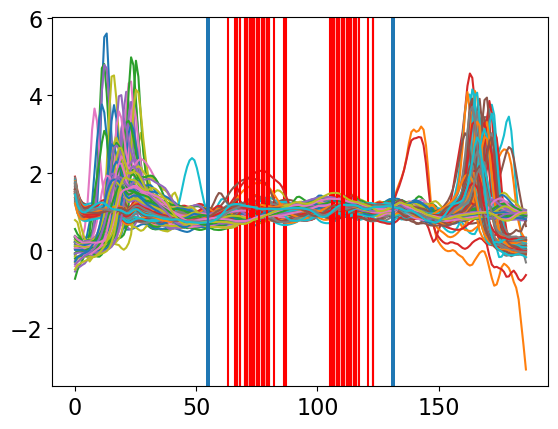

In [25]:
for i in range(len(jup1_array)):
        tempslist = h3ppyfit_doubleorder_loop_multiwidth(wave_micron1st, wave_micron4th, jup1_array[i], jup4_array[i], centers_multi, truecenters_multi, temps, nbg, noff, nsig)     
        
              
        tempsdf = pd.DataFrame(np.array(tempslist[:4]).T, columns = ['Temperatures','Temperature Error','Densities', "Density Error"])
        break
        tempsdf.to_csv(newpath + str(name_arr[i][2:11]) + "_temps.csv", encoding='utf-8', index=False)
        
        fitsarr =  np.asarray([tempslist[4], tempslist[5]])
        np.save(newpath_fits + str(name_arr[i][2:11]) + "_fits.npy", fitsarr)
        
        failperc = tempslist[6]/186 * 100
        successperc = round(100 - failperc, 2)
        
        print("Saved File:", str(name_arr[i][2:11]), "with", successperc, "% successful fits")